In [21]:
import numpy                as np
from   pandas               import *
import pandas               as pd
import uncertainties        as uc
import uncertainties.unumpy as ucu
import pwlf                             # amb aquest packet permet la interpolació lineal
import pickle                           # amb aquest packet podem transportar informació 
import matplotlib.pyplot    as plt       

First we have to take all the data from csv and pickle

In [22]:
#Comencem inicialitzant el nostre vector
PressureLABSONvsTime         = DataFrame()
PressureLABSONvsTime         = pd.read_csv ( 'PressureVsTime_LABSON.csv' , sep = ';' )
# Here we take, with pickle, the object created in TestExp1.ipynb

with open('1.pickle', 'rb') as f:
    mdotLABSONvsPressure     = pickle.load(f) # The protocol version used is detected automatically, so we do not have to specify it.
# print (mdotLABSONvsPressure, PressureLABSONvsTime)

In [23]:
# print(PressureARvsTime)

Here we define the first parameters of our experiments

In [24]:
V      = 0.5  # m^3, Volume of Vessel in LABSON
V_AR   = 0.1  # m^3, volume of vessel in AR
T      = 298  # Temperature
r      = 287  # constant dels gasos
p_atm  = 101.325 # Atmospheric pressure

And here the dataframe is sorted according to Pressure in vessel. This is to make interpolation. Otherwise, results can be weird.

In [25]:
# Calculem el gradient de dPs / dt
PressureLABSONvsTime['dpdt'] = np.gradient( PressureLABSONvsTime.Pressure , PressureLABSONvsTime.Time )
#Later we sort the values according to what we are interested in
mdotLABSONvsPressure         = mdotLABSONvsPressure.sort_values( by   = 'P_vessel')
mdotLABSONvsPressure         = mdotLABSONvsPressure.reset_index( drop = 'True')       #reset index and drop ?

In [26]:
# mdotLABSONvsPressure.reset_index?

In [27]:
# list(mdotLABSONvsPressure.columns) 
# print(mdotLABSONvsPressure)

### Fitting data
We try with piecewice linear interpolation with the package pwlf 
(https://github.com/cjekel/piecewise_linear_fit_py)

In [32]:
# It is better in order to make the exptrapolation and calculate the mdot from experiments, to
# consider as "x" the pressure, and "y" the mdot
x         = ucu.nominal_values(mdotLABSONvsPressure.P_vessel_dim)
y         = ucu.nominal_values(mdotLABSONvsPressure.mdot_s)
# print(x,y)
my_pwlf   = pwlf.PiecewiseLinFit( x , y )  #inicia aquí la sequencia del piecewiselinealfit 
res       = my_pwlf.fit( 2 )               # 
# my_pwlf.slopes
xHat      = np.linspace(min(x), max(x), num=10)   #aqui crea els valors ben separats entre ells
yHat      = my_pwlf.predict(xHat)


xExp      = PressureLABSONvsTime.Pressure
# print(xExp/xExp[0])
# print(xExp)
# my_pwlf.predict?
PressureLABSONvsTime["mdot_s"] = my_pwlf.predict(xExp / xExp[0] )#, sorted_data = 'True')
# print(PressureLABSONvsTime.mdot_s)
PressureLABSONvsTime['k']      = -V * PressureLABSONvsTime.dpdt / ( PressureLABSONvsTime.mdot_s * r * T ) * 1000 # Pressure is in kPa

# We repeat for the AR measurements
# PressureARvsTime             = pd.read_csv('PressureVsTime_AR.csv', sep = ';')
# PressureARvsTime["Pressure"] = 101300 - PressureARvsTime["Depressió kPa"] * 1000
# PressureARvsTime['dpdt']     = np.gradient(PressureARvsTime["Pressure"] , PressureARvsTime["Temps s"] )

# xExpAR                       = PressureARvsTime.Pressure
# PressureARvsTime["mdot_s"]   = my_pwlf.predict(xExpAR/xExpAR[0] , sorted_data = 'True')
# PressureARvsTime['k']        = -V_AR * PressureARvsTime.dpdt / ( PressureARvsTime.mdot_s * r * T)     # Pressure is in Pa

ucu.nominal_values(mdotLABSONvsPressure["mdot_p"]).mean()
ucu.nominal_values(mdotLABSONvsPressure["mdot_p"]).std()

PressureLABSONvsTime ["tau"] = PressureLABSONvsTime ["Time"]    * ucu.nominal_values(mdotLABSONvsPressure["mdot_p"]).mean() /V
# PressureARvsTime     ["tau"] = PressureARvsTime     ["Temps s"] * ucu.nominal_values(mdotLABSONvsPressure["mdot_p"]).mean() /V_AR

# print(PressureLABSONvsTime.tau)

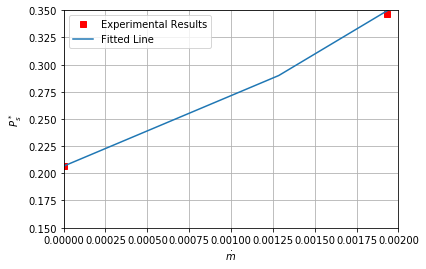

In [38]:
# %matplotlib widget
fig  = plt.figure()#'mdot')

figure = fig.add_subplot(1,1,1)
#
figure.plot( y , x , 'sr', label = 'Experimental Results' )
figure.plot( yHat , xHat , '-', label = 'Fitted Line' )

figure.set_ylabel( '$P_s^*$')
figure.set_xlabel( "$\dot{m}$" )
axes1 = plt.gca()
figure.legend()
axes1.set_xlim([0.00,0.002])
axes1.set_ylim([0.15,0.35])
plt.grid();

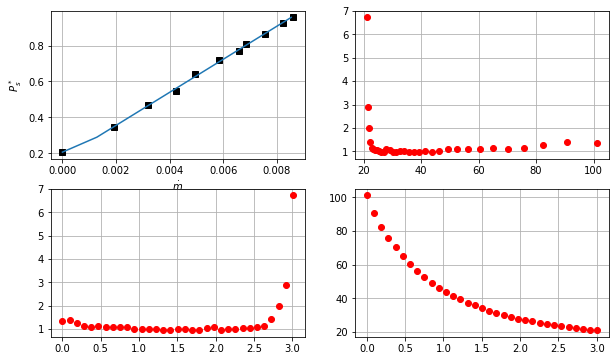

In [34]:
# %matplotlib widget
# plt.grid() 
# Aquí hi fem la segona gràfica. És la q es troba a dalt a la dreta
fig1  = plt.figure(figsize=(10,6))#'mdot')
fig11 = fig1.add_subplot(2,2,1)
#
fig11.plot( y , x , 'ks' )
fig11.plot( yHat , xHat , '-' )

fig11.set_ylabel( '$P_s^*$')
fig11.set_xlabel( "$\dot{m}$" )
#axes1 = plt.gca()
# axes1.set_xlim([0.00,0.002])
# axes1.set_ylim([0.15,0.35])
plt.grid();
fig11 = fig1.add_subplot(2,2,2)
plt.grid() 
# fig2  = plt.figure()
# fig22 = fig2.add_subplot(1,1,1
fig11.plot (PressureLABSONvsTime.Pressure , PressureLABSONvsTime.k , 'ro')
# fig11.plot (PressureARvsTime.Pressure/1000, PressureARvsTime.k     , 'b^')
# tercera gràfica. es troba a baix a l'esquerra
# fig3  = plt.figure()
# fig33 = fig3.add_subplot(1,1,1)
# plt.figure ('k_tau')
#plt.subplot
fig11 = fig1.add_subplot(2,2,3)
plt.grid() 
fig11.plot   (PressureLABSONvsTime.tau , PressureLABSONvsTime.k , 'ro' )
f
# fig11.plot   (PressureARvsTime.tau     , PressureARvsTime.k     , 'b^' )

# aquí hi posem l'última gràfica. Aquesta és abaix a la dreta
# fig4  = plt.figure()
# fig44 = fig4.add_subplot(1,1,1)
# plt.figure('Pressure_tau')
#plt.subplot
fig11 = fig1.add_subplot(2,2,4)
plt.grid() 
fig11.plot(PressureLABSONvsTime.tau,PressureLABSONvsTime.Pressure,'ro')
# fig11.plot(PressureARvsTime.tau,PressureARvsTime.Pressure/1000,'b^')

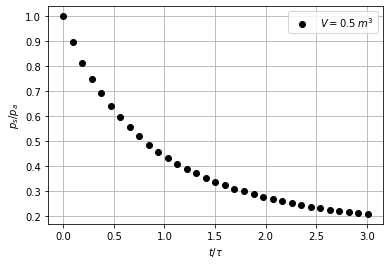

In [35]:
# %matplotlib widget

ps_mu_fig = plt.figure()
fig1 = ps_mu_fig.add_subplot(1,1,1)

fig1.plot(PressureLABSONvsTime.tau,PressureLABSONvsTime.Pressure/p_atm,'ko',label = '$V = 0.5\;{m^3}$')
# fig1.plot(PressureARvsTime.tau,PressureARvsTime.Pressure/1000/p_atm,'r^',label = '$V = 0.1\;{m^3}$')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$p_s/p_a$')
fig1.legend()
fig1.grid();

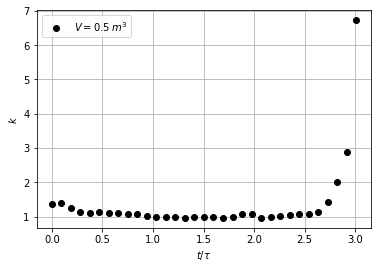

In [36]:
# %matplotlib widget

kvst = plt.figure()
kvst1 = kvst.add_subplot(1,1,1)

kvst1.plot(PressureLABSONvsTime.tau,PressureLABSONvsTime.k,'ko',label = '$V = 0.5\;{m^3}$')
# kvst1.plot(PressureARvsTime.tau,PressureARvsTime.k,'r^',label = '$V = 0.1\;{m^3}$')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$k$')
plt.legend()
plt.grid();

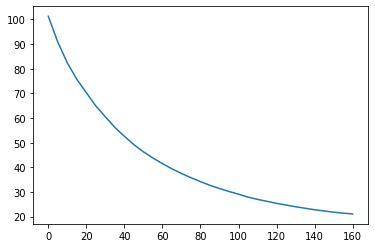

In [37]:
plt.plot(PressureLABSONvsTime.Time,PressureLABSONvsTime.Pressure)